<a href="https://colab.research.google.com/github/iamshnoo/face_recognition/blob/master/mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np


In [50]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ## Conv layers
        # input of size (1 x 227 x 227)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=(4, 4), stride=4, padding=0) # VALID
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=1, padding=2) # SAME
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding=1) # SAME
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding=1) # SAME
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1) # SAME
        
        ## Max-Pool layer 
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        ## Linear layers
        self.fc1 = nn.Linear(in_features=9216, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=136)
        
        ## Dropout 
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout4 = nn.Dropout(p=0.4)
        self.dropout6 = nn.Dropout(p=0.6)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=96, eps=1e-05)
        self.bn2 = nn.BatchNorm2d(num_features=256, eps=1e-05)
        self.bn3 = nn.BatchNorm2d(num_features=384, eps=1e-05)
        self.bn4 = nn.BatchNorm2d(num_features=384, eps=1e-05)
        self.bn5 = nn.BatchNorm2d(num_features=256, eps=1e-05)
        self.bn6 = nn.BatchNorm1d(num_features=4096, eps=1e-05)
        self.bn7 = nn.BatchNorm1d(num_features=4096, eps=1e-05)
        
        ## Local response normalization
        # if size=r=2 and a neuron has a strong activation, it will inhibit the activation
        # of the neurons located in the feature maps immediately above and below its own.
#         self.lrn = LocalResponseNorm(size=2, alpha=0.00002, beta=0.75, k=1)  # lrn is on new pytorch version apparently
        
        # Custom weights initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight = nn.init.xavier_uniform_(m.weight, gain=1)
            elif isinstance(m, nn.Linear):
                # FC layers have weights initialized with Glorot uniform initialization
                m.weight = nn.init.xavier_uniform_(m.weight, gain=1)

    def forward(self, x):
        
        ## Conv layers
        x = F.elu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.elu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        
        x = F.elu(self.conv3(x))
        x = self.bn3(x)
        x = self.dropout4(x)
        
        x = F.elu(self.conv4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        
        x = F.elu(self.conv5(x))
        x = self.bn5(x)
        x = self.pool(x)

        ## Flatten
        x = x.view(x.size(0), -1) 
        
        ## Fully connected layers
        x = F.elu(self.fc1(x))
        x = self.bn6(x)
        x = self.dropout6(x)
        
        x = F.elu(self.fc2(x))
        x = self.bn6(x)
        x = self.dropout6(x)
        

        x = self.fc3(x)
    
        return x
'''
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs      
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel       
        ## input image size is 224 * 224 pixels        
        # first convolutional layer
        ## (W-F)/S + 1 = (224-5)/1 + 1 = 220
        ## self.conv1 = nn.Conv2d(1, 32, 5) # the output Tensor for one image, will have the dimensions: (32, 220, 220)
        
        # NOTE : This netork architecture is largely based on the LeNet Architecture with some modifications 
        #        to suit the needs of this project and the constraints of my hardware.
       
        ## input image size is 96 * 96 pixels
        # input image size is 224 * 224 pixels
        # first convolutional layer
        self.conv1 = torch.nn.Conv2d(1,32,5) # (32,220,220) output tensor # (W-F)/S + 1 = (224-5)/1 + 1 = 220
        
        # first Max-pooling layer
        self.pool1 = torch.nn.MaxPool2d(2,2) # (32,110,110) output tensor
        
        # second convolutional layer
        self.conv2 = torch.nn.Conv2d(32,64,5) # (64,106,106) output tensor # (W-F)/S + 1 = (110-5)/1 + 1 = 106
        
        # second Max-pooling layer
        self.pool2 = torch.nn.MaxPool2d(2,2) # (64,53,53) output tensor
        
        # Fully connected layer
        self.fc1 = torch.nn.Linear(64*53*53, 1000)   
        self.fc2 = torch.nn.Linear(1000, 500)       
        self.fc3 = torch.nn.Linear(500, 136)        
        self.drop1 = nn.Dropout(p=0.4)
        self.drop2 = nn.Dropout(p=0.3)
        
        
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
          
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop1(x)
      
        # Flatten before passing to the fully-connected layers.
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop2(x)
        
        x = self.fc3(x)
        
        # a modified x, having gone through all the layers of your model, should be returned
        return x

'''

# I tried to use my laptop's gpu. It wasn't working properly.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout2): Dropout(p=0.2)
  (dropout4): Dropout(p=0.4)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_

In [51]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-03-26 10:02:30--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.82.12
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.82.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.2’

train-test-data.zip 100%[===================>] 322.93M  73.2MB/s    in 4.4s    

2019-03-26 10:02:34 (73.2 MB/s) - ‘/data/train-test-data.zip.2’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [0]:
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2


class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    

    
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [0]:
from torchvision import transforms, utils

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose( [Rescale(250) , RandomCrop(227) , Normalize() , ToTensor()] )
                                     
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [61]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 227, 227]) torch.Size([68, 2])
1 torch.Size([1, 227, 227]) torch.Size([68, 2])
2 torch.Size([1, 227, 227]) torch.Size([68, 2])
3 torch.Size([1, 227, 227]) torch.Size([68, 2])


In [0]:
# load training data in batches
batch_size = 40

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)


In [0]:
# load test data in batches
batch_size = 40

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # I tried to use my laptop's gpu. It wasn't working properly.
        images = images.to(device)
        key_pts = key_pts.to(device)
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [69]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 227, 227])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


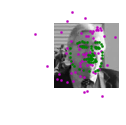

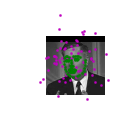

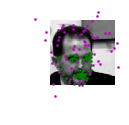

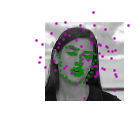

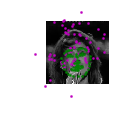

In [75]:
# visualize the output
# by default this shows a batch of 5 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot( batch_size, 1, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        
        # I tried to use my laptop's gpu. It wasn't working properly.
        if torch.cuda.is_available():
            image = image.cpu()
            
        image = image.data
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        
        # I tried to use my laptop's gpu. It wasn't working properly.
        if torch.cuda.is_available():
            predicted_key_pts = predicted_key_pts.cpu()
            
        predicted_key_pts = predicted_key_pts.data
        predicted_key_pts = predicted_key_pts.numpy()
        
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        
        if gt_pts is not None:
            
            ground_truth_pts = gt_pts[i] 
            
            # I tried to use my laptop's gpu. It wasn't working properly.
            if torch.cuda.is_available():
                ground_truth_pts = ground_truth_pts.cpu()  
                
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [0]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()
# criterion = nn.MSELoss() # not giving much better accuracy as of the all attempts I made.

optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [0]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        # print('Epoch: {}'.format(epoch + 1)) # for debugging
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #print('Batch: {}'.format(batch_i+1)) # for debugging
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            key_pts, images = key_pts.to(device), images.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [81]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.11158340573310851
Epoch: 1, Batch: 20, Avg. Loss: 0.1130926713347435
Epoch: 1, Batch: 30, Avg. Loss: 0.11026529669761657
Epoch: 1, Batch: 40, Avg. Loss: 0.10258268937468529
Epoch: 1, Batch: 50, Avg. Loss: 0.10231155976653099
Epoch: 1, Batch: 60, Avg. Loss: 0.10084166526794433
Epoch: 1, Batch: 70, Avg. Loss: 0.09760139435529709
Epoch: 1, Batch: 80, Avg. Loss: 0.10677219033241273
Epoch: 2, Batch: 10, Avg. Loss: 0.09353654682636262
Epoch: 2, Batch: 20, Avg. Loss: 0.09769986048340798
Epoch: 2, Batch: 30, Avg. Loss: 0.10181592702865601
Epoch: 2, Batch: 40, Avg. Loss: 0.1024124264717102
Epoch: 2, Batch: 50, Avg. Loss: 0.09246866852045059
Epoch: 2, Batch: 60, Avg. Loss: 0.09283061996102333
Epoch: 2, Batch: 70, Avg. Loss: 0.09068194925785064
Epoch: 2, Batch: 80, Avg. Loss: 0.09116013422608375
Epoch: 3, Batch: 10, Avg. Loss: 0.09673741385340691
Epoch: 3, Batch: 20, Avg. Loss: 0.08423674628138542
Epoch: 3, Batch: 30, Avg. Loss: 0.08444224372506141
Epoch: 3, Batc

In [82]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 227, 227])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


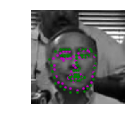

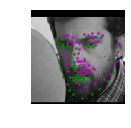

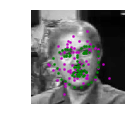

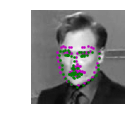

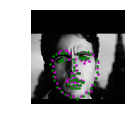

In [83]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

In [0]:

#!mkdir saved_models
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# NOTE : saved_models/keypoints_model_1.pt is for the modified LeNet I am finally using.
#        saved_models/keypoints_model_0.pt is a previous model that I had used. It is no longer needed.

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

Filter :
[[-0.04668201 -0.05926383 -0.02887374 -0.03357554]
 [ 0.03872482 -0.0396721   0.0289996   0.02168359]
 [-0.00604953  0.0029878  -0.01465029  0.06085439]
 [ 0.07032593  0.01298657  0.01230183 -0.01158715]]
Shape : (4, 4)


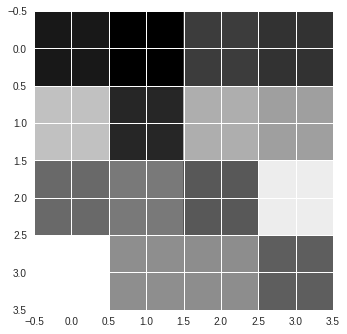

In [87]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 11

print("Filter :")
print(w[filter_index][0])
print("Shape : " + str(w[filter_index][0].shape))

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

In [98]:
#!mkdir /data/images
!wget -P /data/images/ https://github.com/iamshnoo/Udacity-CVND-P1---Facial-Keypoint-Detection/blob/master/images/mona_lisa.jpg

--2019-03-26 10:35:08--  https://github.com/iamshnoo/Udacity-CVND-P1---Facial-Keypoint-Detection/blob/master/images/mona_lisa.jpg
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/data/images/mona_lisa.jpg’

mona_lisa.jpg           [ <=>                ]  57.24K  --.-KB/s    in 0.03s   

2019-03-26 10:35:09 (2.19 MB/s) - ‘/data/images/mona_lisa.jpg’ saved [58617]



[[-0.00657063 -0.0432454   0.02237284  0.00257381]
 [ 0.03115582  0.01097753  0.07182786  0.04757997]
 [-0.01688039  0.0101563   0.0625659   0.02398661]
 [ 0.00101425  0.02390072 -0.04561418  0.0569915 ]]
(4, 4)


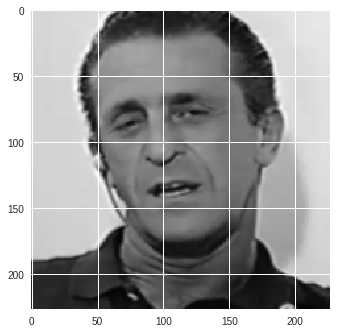

In [125]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 1

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
# plt.imshow(w[filter_index][0], cmap='gray')


idx_img = 10
img = np.squeeze(test_images[idx_img].data.cpu().numpy())

# plt.imshow(img, cmap="gray")

filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(filtered_img, cmap="gray")